In [1]:
# matplotlib 用于绘图
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# 处理数据的库
import numpy as np
import sklearn
import pandas as pd
# 系统库
import os
import sys
import time
# TensorFlow的库
import tensorflow as tf
from tensorflow import keras

In [ ]:
# wide deep tensorflow2

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [79]:
from sklearn.model_selection import train_test_split
# test_size 指的是划分的训练集和测试集的比例
# test_size 默认值为0.25 表示数据分四份，测试集占一份
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7, test_size = 0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state = 11, test_size = 0.25)

In [80]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 训练集数据使用的是 fit_transform，和验证集与测试集中使用的 transform 是不一样的
# fit_transform 可以计算数据的均值和方差并记录下来
# 验证集和测试集用到的均值和方差都是训练集数据的，所以二者的归一化使用 transform 即可
# 归一化只针对输入数据， 标签不变
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [81]:
x_train_scaled.shape

(11610, 8)

In [82]:
y_train.shape


(11610,)

In [28]:
x_train_all.shape

(15480, 8)

In [26]:
x_train.shape[1:]

(8,)

In [5]:
# 函数式API实现Wide & Deep model
input = keras.layers.Input(shape=x_train.shape[1:])
# """
# 函数式API就是我们可以将模型中的层结构当做函数来用
# 如下所示就是函数式API，将input当做参数传给了hidden1
# hidden1又当做参数传递给了hidden2
# """
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# """
# input是wide模型的输入
# hidden2是deep模型的输出
# concatenate将二者拼接，并将拼接之后的结果传递给output layer
# """
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)
# """
# 固化model
# """
model = keras.models.Model(inputs = [input],
                          outputs = [output])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [9]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [11]:
# 子类API实现Wide & Deep model
"""
子类API就是集成父类来实现
我们首先要定义一个Wide & Deep模型父类
然后通过集成该父类进行模型的构建
"""
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """
        定义模型的层次
        """
        self.hidden1_layer = keras.layers.Dense(30, activation = 'relu')
        self.hidden2_layer = keras.layers.Dense(30, activation = 'relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        """
        完成模型的正向计算
        """
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

model = WideDeepModel()
model.build(input_shape = (None, 8))
model.summary()

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  270       
_________________________________________________________________
dense_7 (Dense)              multiple                  930       
_________________________________________________________________
dense_8 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 编译模型， 损失函数为均方误差函数，优化函数为随机梯度下降
model.compile(loss="mean_squared_error", optimizer = keras.optimizers.SGD(0.001))
# 回调函数使用了EarlyStopping，patience设为5， 阈值设置为1e-2
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

In [35]:
x_train_scaled.shape

(11610, 8)

In [36]:
y_train.shape

(11610,)

In [13]:
history = model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs = 100,
                   callbacks= callbacks)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 1.7925 - val_loss: 0.7244
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6265 - val_loss: 0.6484
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5824 - val_loss: 0.6172
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5570 - val_loss: 0.5951
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5381 - val_loss: 0.5748
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5231 - val_loss: 0.5562
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5116 - val_loss: 0.5429
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5014 - val_loss: 0.5311
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4936 - val_loss: 0.5241
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4851 - val_lo

In [14]:
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4136


0.41359058022499084

In [15]:
"""
多输入结构
"""
input_wide = keras.layers.Input(shape=[5]) # 前五个作为wide的输入
input_deep = keras.layers.Input(shape=[6]) # 后六个作为deep的输入
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)

"""
固化model
"""
model = keras.models.Model(inputs = [input_wide, input_deep],
                          outputs = [output])

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

In [18]:
"""
x_wide:数据集前5个特征
x_deep:数据集后6个特征
"""
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]

# 编译模型， 损失函数为均方误差函数，优化函数为随机梯度下降
model.compile(loss="mean_squared_error", optimizer = keras.optimizers.SGD(0.001))
# 回调函数使用了EarlyStopping，patience设为5， 阈值设置为1e-2
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

history = model.fit([x_train_scaled_wide, x_train_scaled_deep], y_train,
                   validation_data=([x_valid_scaled_wide, x_valid_scaled_deep], y_valid),
                   epochs = 100,
                   callbacks= callbacks)

Epoch 1/100
363/363 [==============================] - 2s 3ms/step - loss: 2.1159 - val_loss: 0.8848
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.7449 - val_loss: 0.7248
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.6535 - val_loss: 0.6695
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6082 - val_loss: 0.6310
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5751 - val_loss: 0.6014
Epoch 6/100
363/363 [==============================] - 1s 4ms/step - loss: 0.5506 - val_loss: 0.5769
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5330 - val_loss: 0.5613
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5198 - val_loss: 0.5478
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5090 - val_loss: 0.5363
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5001 - val_lo

In [19]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4286


0.42855796217918396

In [ ]:
# https://blog.csdn.net/qq_42580947/article/details/105302840

In [ ]:
# https://zhuanlan.zhihu.com/p/348968507

In [110]:
from sklearn.datasets import load_breast_cancer

demo_data = load_breast_cancer()
# print(demo_data.DESCR)
# print(demo_data.data.shape)
# print(demo_data.target.shape)

In [114]:
# demo_data.data.shape

(569, 30)

In [93]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    demo_data.data, demo_data.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(319, 30) (319,)
(107, 30) (107,)
(143, 30) (143,)


In [94]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    demo_data.data, demo_data.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(319, 30) (319,)
(107, 30) (107,)
(143, 30) (143,)


In [95]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 训练集数据使用的是 fit_transform，和验证集与测试集中使用的 transform 是不一样的
# fit_transform 可以计算数据的均值和方差并记录下来
# 验证集和测试集用到的均值和方差都是训练集数据的，所以二者的归一化使用 transform 即可
# 归一化只针对输入数据， 标签不变
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [96]:
x_train_scaled.shape

(319, 30)

In [97]:
y_train.shape

(319,)

In [71]:
input_wide = tf.keras.layers.Input(shape=[15], name='input_wide')
input_deep = tf.keras.layers.Input(shape=[15], name='input_deep')
hidden1 = tf.keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
concat = tf.keras.layers.concatenate([input_wide, hidden2])
output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)


model = tf.keras.models.Model(inputs = [input_wide, input_deep], outputs = [output])

In [63]:
# test 
tf.random.set_seed(2)
inputs = [np.array([list(range(15))]), np.array([list(range(15))])]

model(inputs)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99916446]], dtype=float32)>

In [64]:
# plot model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [43]:
class WideDeepModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(30, activation='relu')
        self.concat = tf.keras.layers.concatenate
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_wide, input_deep = inputs
        output_deep = self.hidden1(input_deep)
        output_deep = self.hidden2(output_deep)
        concat_input = self.concat([input_wide, output_deep])
        output = self.dense(concat_input)
        return output

    def build_graph(self, shapes):
        shape1, shape2 = shapes
        input_wide = tf.keras.layers.Input(shape=shape1)
        input_deep = tf.keras.layers.Input(shape=shape2)
        return tf.keras.models.Model(inputs=[input_wide, input_deep], outputs=[self.call([input_wide, input_deep])])

In [32]:
model = WideDeepModel()

In [33]:
# plot model
tf.keras.utils.plot_model(
    model.build_graph([(15), (15)]),
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [99]:
class WideDeepModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(30, activation='relu')
        self.concat = tf.keras.layers.concatenate
        self.dense1 = tf.keras.layers.Dense(1, activation='sigmoid', name='output_1')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name='output_2')

    def call(self, inputs):
        input_wide, input_deep = inputs
        output_deep = self.hidden1(input_deep)
        output_deep = self.hidden2(output_deep)
        concat_input = self.concat([input_wide, output_deep])
        output1 = self.dense1(concat_input)
        output2 = self.dense2(concat_input)
        return [output1, output2]

#     def build_graph(self, shapes):
#         x_wide_shape, x_deep_shape = shapes
#         input_wide = tf.keras.layers.Input(shape=[15], name='input_wide')
#         input_deep = tf.keras.layers.Input(shape=[15], name='input_deep')
#         inputs = [input_wide, input_deep]
#         return tf.keras.models.Model(inputs=inputs, outputs=self.call(inputs))

In [100]:
# test 
# load model
model = WideDeepModel()

# load model by Squential
# model = tf.keras.models.Sequential([WideDeepModel(), ])
# # input_shape = [(None, 15), (None, 15)]
# # model.build(input_shape=(None, 15))
# # model.summary()

inputs = [np.array([list(range(15))]).astype('float32'), np.array([list(range(15))]).astype('float32')]

model(inputs)


[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99916446]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.5182046e-05]], dtype=float32)>]

In [101]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

In [102]:
## specific loss and loss weights
losses = {
    "output_1": "binary_crossentropy",
    "output_2": "binary_crossentropy",
}
loss_weights = {"output_1": 1.0, "output_2": 2}
model.compile(loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

In [103]:
x_train_scaled_wide = x_train_scaled[:, :15]
x_train_scaled_deep = x_train_scaled[:, 15:]
x_valid_scaled_wide = x_valid_scaled[:, :15]
x_valid_scaled_deep = x_valid_scaled[:, 15:]
x_test_scaled_wide = x_test_scaled[:, :15]
x_test_scaled_deep = x_test_scaled[:, 15:]


history = model.fit([x_train_scaled_wide, x_train_scaled_deep], y_train,
                   validation_data=([x_valid_scaled_wide, x_valid_scaled_deep], y_valid),
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - 2s 55ms/step - loss: 2.0272 - output_1_loss: 0.6256 - output_2_loss: 0.7008 - output_1_accuracy: 0.6928 - output_2_accuracy: 0.5266 - val_loss: 1.8866 - val_output_1_loss: 0.5655 - val_output_2_loss: 0.6605 - val_output_1_accuracy: 0.7850 - val_output_2_accuracy: 0.5327
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6873 - output_1_loss: 0.5277 - output_2_loss: 0.5798 - output_1_accuracy: 0.8182 - output_2_accuracy: 0.6959 - val_loss: 1.6009 - val_output_1_loss: 0.4876 - val_output_2_loss: 0.5566 - val_output_1_accuracy: 0.8505 - val_output_2_accuracy: 0.6916
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 1.4276 - output_1_loss: 0.4532 - output_2_loss: 0.4872 - output_1_accuracy: 0.9028 - output_2_accuracy: 0.8370 - val_loss: 1.3413 - val_output_1_loss: 0.4184 - val_output_2_loss: 0.4615 - val_output_1_accuracy: 0.8972 - val_output_2_accuracy: 0.8505
Epoch 4/100
10/10 [=========

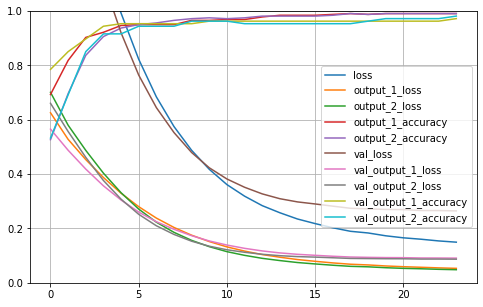

In [108]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [109]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.2010 - output_1_loss: 0.0721 - output_2_loss: 0.0644 - output_1_accuracy: 0.9860 - output_2_accuracy: 0.9790


[0.2010122537612915,
 0.07214956730604172,
 0.064431332051754,
 0.9860140085220337,
 0.9790209531784058]

In [104]:
x_train_scaled_wide.shape

(319, 15)

In [105]:
y_train.shape

(319,)

In [106]:
x_valid_scaled_wide.shape

(107, 15)

In [107]:
y_valid.shape

(107,)

In [ ]:
# https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b

In [ ]:
real = {
    colname : fc.numeric_column(colname) \
          for colname in \
            (’dep_delay,taxiout,distance’).split(’,’)
}

sparse = {
      'origin' : fc.categorical_column_with_hash_bucket(’origin’, hash_bucket_size=1000),
      'dest'   : fc.categorical_column_with_hash_bucket(’dest’, hash_bucket_size=1000)
}

In [ ]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in real.keys()
}

inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') \
          for colname in sparse.keys()
})

In [ ]:
embed = {
       'embed_{}'.format(colname) : fc.embedding_column(col, 10) \
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : fc.indicator_column(col) \
          for colname, col in sparse.items()
}

In [ ]:
deep = tf.keras.layers.DenseFeatures(real.values())(inputs)
deep = tf.keras.layers.Dense(64, activation='relu')(deep)
deep = tf.keras.layers.Dense(16, activation='relu')(deep)
output = tf.keras.layers.Dense(1, activation='sigmoid')(deep)
model = tf.keras.Model(inputs, output)

In [ ]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
    both = tf.keras.layers.concatenate([deep, wide])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = wide_and_deep_classifier(inputs, sparse.values(), real.values(), [64, 16])

In [ ]:
# feature columns input Keras Functional API
# https://stackoverflow.com/questions/54375298/how-to-use-tensorflow-feature-columns-as-input-to-a-keras-model

In [115]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd

#!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
dataframe = pd.read_csv(csv_file, nrows = 10000)
dataframe.head()

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# Define method to create tf.data dataset from Pandas Dataframe
# This worked with tf 2.0 but does not work with tf 2.2
def df_to_dataset_tf_2_0(dataframe, label_column, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    #labels = dataframe.pop(label_column)
    labels = dataframe[label_column]

    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

def df_to_dataset(dataframe, label_column, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(label_column)
    #labels = dataframe[label_column]

    ds = tf.data.Dataset.from_tensor_slices((dataframe.to_dict(orient='list'), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, label_column = 'target', batch_size=batch_size)
val_ds = df_to_dataset(val,label_column = 'target',  shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, label_column = 'target', shuffle=False, batch_size=batch_size)

age = feature_column.numeric_column("age")

feature_columns = []
feature_layer_inputs = {}

# numeric cols
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(feature_column.numeric_column(header))
    feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

# bucketized cols
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35])
feature_columns.append(age_buckets)

# indicator cols
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)
feature_layer_inputs['thal'] = tf.keras.Input(shape=(1,), name='thal', dtype=tf.string)

# embedding cols
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed cols
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)



feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer_outputs = feature_layer(feature_layer_inputs)

x = layers.Dense(128, activation='relu')(feature_layer_outputs)
x = layers.Dense(64, activation='relu')(x)

baggage_pred = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=baggage_pred)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds)

16384/13273 [=====================================] - 0s 0us/step
193 train examples
49 validation examples
61 test examples


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\tensorflow\python\keras\engine\functional.py:588: UserWarning: Input dict contained keys ['sex', 'cp', 'fbs', 'restecg', 'exang'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


39/39 [==============================] - 2s 5ms/step - loss: 0.7388 - accuracy: 0.7150


In [116]:
dataframe

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1
